### 1. Import Packages

In [1]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer

# Librerie per la Hyperparameters Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per il Machine Learning
from sklearn import svm
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la curva ROC
from sklearn.metrics import roc_curve, auc

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [2]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M172,M173,M174,M175,M176,M177,M178,M179,M180,M181
0,Plasma,Adenocarcinoma,Former,F,194,168,77,105985,118,15489,...,195,1606,300,108,7203,43,59,1009,383,68
1,Plasma,Adenocarcinoma,Former,F,215,143,154,100462,133,13534,...,184,364,1364,160,11910,82,99,136,1021,165
2,Plasma,Adenocarcinoma,Current,F,104,67,45,75301,94,7390,...,189,157,884,73,6372,59,35,115,530,72
3,Plasma,Adenocarcinoma,Current,M,360,642,82,42097,84,50943,...,320,1621,461,104,14011,69,86,845,1309,127
4,Plasma,Adenocarcinoma,Current,M,96,137,95,112346,168,41987,...,84,769,266,158,18140,40,87,1213,1037,149


### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [3]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Eliminiamo le righe con valori nulli all'interno delle colonne "HealthState" e "Sex"
df = df.dropna(subset=["HealthState", "Sex"])

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M173,M174,M175,M176,M177,M178,M179,M180,M181,Output
0,Plasma,Adenocarcinoma,0,1,194,168,77,105985,118,15489,...,1606,300,108,7203,43,59,1009,383,68,1
1,Plasma,Adenocarcinoma,0,1,215,143,154,100462,133,13534,...,364,1364,160,11910,82,99,136,1021,165,1
2,Plasma,Adenocarcinoma,1,1,104,67,45,75301,94,7390,...,157,884,73,6372,59,35,115,530,72,1
3,Plasma,Adenocarcinoma,1,0,360,642,82,42097,84,50943,...,1621,461,104,14011,69,86,845,1309,127,1
4,Plasma,Adenocarcinoma,1,0,96,137,95,112346,168,41987,...,769,266,158,18140,40,87,1213,1037,149,1


### 3. Extract X & Y

In [4]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

In [5]:
# KNNImputer
imputer_knn = KNNImputer(n_neighbors=2)
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_11424/3462717103.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 3.2 Train-test Split

In [6]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Initial Model Build

In [7]:
# Definiamo il modello Support Vector Machine con gli iperparametri di default
model = svm.SVC(probability=True)

# Addestriamo il modello
model.fit(X_train_knn, y_train_knn)

# Eseguiamo le previsioni sui dati di test
y_pred_knn = model.predict(X_test_knn)

### 5. Initial Model Evalutation

In [8]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.48484848484848486
Precision: 0.5
Recall: 0.9411764705882353
F1-score: 0.6530612244897959
ROC AUC: 0.47058823529411764


Le prestazioni iniziali sono estremamente deludenti: abbiamo un'accuratezza del 48%, una Precision del 50% e una Recall dell'94%. Proviamo con la K-Fold Cross Validation.

In [9]:
# Testiamo diverse configurazioni di K
max = 0
k_best = 0
for k in range(5, 11): 
    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    model = svm.SVC()
    scores = cross_val_score(model, X_knn, y, cv=kfolds)
    mean = np.mean(scores)
    if mean > max: 
        max = mean
        k_best = k
    print(f"K={k}, Accuratezza Media: {mean}")
    
print("-------------------------------------------")
print(f"K ottimale: {k_best}")
print(f"Accuratezza media massima: {max}")

K=5, Accuratezza Media: 0.5952651515151515
K=6, Accuratezza Media: 0.601410934744268
K=7, Accuratezza Media: 0.6019668737060042
K=8, Accuratezza Media: 0.5955357142857143
K=9, Accuratezza Media: 0.5955165692007798
K=10, Accuratezza Media: 0.5955882352941176
-------------------------------------------
K ottimale: 7
Accuratezza media massima: 0.6019668737060042


Abbiamo ottenuto le prestazioni migliori con un numero di fold pari a 7.

In [10]:
# Creiamo l'oggetto K-Fold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

In [11]:
# Creiamo un nuovo modello Support Vector Machine
model_2 = svm.SVC()

# Definiamo la griglia con i parametri da testare
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.01, 0.1],
    'class_weight': [None, 'balanced'],
    'probability': [True]
}

# Creiamo l'oggetto GridSearchCV
grid_search = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=k_best)
grid_search.fit(X_knn, y)

# Visualizziamo i risultati
best_params = grid_search.best_params_
print("Iperparametri migliori:", best_params)

Iperparametri migliori: {'C': 1, 'class_weight': None, 'gamma': 0.01, 'kernel': 'linear', 'probability': True}


In [12]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = svm.SVC(**best_params)

In [13]:
# Valutiamo le prestazioni del modello con gli iperparametri ottimizzati
best_model.fit(X_train_knn, y_train_knn)
y_pred_knn = best_model.predict(X_test_knn)

# Calcoliamo le metriche
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

# Visualizziamo le metriche
print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.696969696969697
Precision: 0.7058823529411765
Recall: 0.7058823529411765
F1-score: 0.7058823529411765
ROC AUC: 0.6966911764705883


Valutiamo le prestazioni con la K-Fold Cross Validation.

In [14]:
# KFold Cross Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')
print(f'Deviazione standard: {scores.std()}')

Accuratezza media: 0.8043478260869567
Deviazione standard: 0.09135794049739444


### 7. Feature Selection
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Otteniamo le correlazioni tra le features
corrmat = X_top.corr()

top_corr_features = corrmat.index

plt.figure(figsize=(k_fs, k_fs))

Generiamo il grafico delle correlazioni

g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 9. Results

I risultati della ricerca sono i seguenti:

In [15]:
# Numero ottimale di fold
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

# Modello BernoulliNB con gli iperparametri ottimizzati
model = svm.SVC(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
y_pred = cross_val_predict(model, X_knn, y, cv=kfolds, method='predict_proba')

# Scegliamo na soglia (threshold) per trasformare le probabilità in etichette binarie
threshold = 0.5
y_pred = (y_pred[:, 1] > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
f1 = metrics.f1_score(y, y_pred)
roc_auc = metrics.roc_auc_score(y, y_pred)

In [16]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

print("------------------------")
print(f'Matrice di confusione:\n {metrics.confusion_matrix(y, y_pred)}')
print("------------------------")
print(f'Migliori iperparametri:')
for h in best_params:
    print(f'- {h}: {best_params[h]}')

------------------------
Accuracy: 0.8037
Precision: 0.8269
Recall: 0.8600
F1-score: 0.8431
ROC AUC: 0.7871
------------------------
Matrice di confusione:
 [[45 18]
 [14 86]]
------------------------
Migliori iperparametri:
- C: 1
- class_weight: None
- gamma: 0.01
- kernel: linear
- probability: True


### 10. ROC Curve

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, random_state=42)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

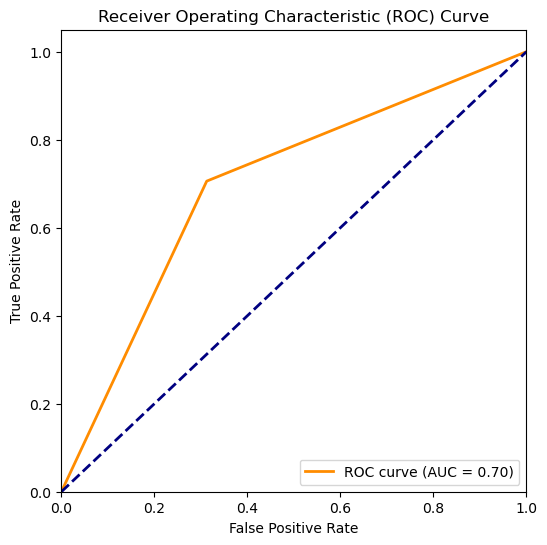

In [18]:
# Calcoliamo la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcoliamo l'area sotto la curva ROC
roc_auc = auc(fpr, tpr)

# Grafichiamo la curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")